In [1]:
import transformers as trf
import numpy as np
import torch as pt
import pandas as pd
import tqdm
import json

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
bert = trf.BertForMaskedLM.from_pretrained('bert-base-uncased')
tkr = trf.BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
cat_tk_id = tkr.convert_tokens_to_ids(['cat'])[0]
dot_tk_id = tkr.convert_tokens_to_ids(['.'])[0]

In [4]:
data = []
# anonymized
path_to_conceptnet = '../data/ConceptNet/'
with open(f'{path_to_conceptnet}/test.jsonl', 'r') as f:
    for line in f.readlines():
        data.append(json.loads(line))

In [5]:
data[:2]

[{'sub': 'alive',
  'obj': 'think',
  'pred': 'HasSubevent',
  'masked_sentences': ['One of the things you do when you are alive is [MASK].'],
  'obj_label': 'think',
  'uuid': 'd4f11631dde8a43beda613ec845ff7d1'},
 {'sub': 'analyse',
  'obj': 'paralysis',
  'pred': 'HasSubevent',
  'masked_sentences': ['Something that might happen when you analyse something is [MASK].'],
  'obj_label': 'paralysis',
  'uuid': '4b0c94af3a9339e4e5a3f9cbc057fac8'}]

In [6]:
list(map(lambda x: x['masked_sentences'][0].replace("[MASK]", tkr.mask_token), data[:2]))

['One of the things you do when you are alive is [MASK].',
 'Something that might happen when you analyse something is [MASK].']

In [7]:
def get_obj(x):
    try:
        return x['obj_label']
    except:
        print(x)
        return None

correct_ans = list(map(get_obj, data))

In [8]:
correct_ans_tks = list(map(lambda x: tkr.convert_tokens_to_ids([x]), correct_ans))

In [9]:
# DATA IS CLEAN
[x for x in correct_ans_tks if len(x) > 1]

[]

In [10]:
correct_ans_tks = [x[0] for x in correct_ans_tks]

In [11]:
data_tks = list(tqdm.tqdm(map(lambda x: tkr.encode(x['masked_sentences'][0].replace("[MASK]", tkr.mask_token)), data)))

29774it [00:07, 4060.66it/s]


In [12]:
data_tks_targets = list(map(lambda x: x.index(tkr.mask_token_id), data_tks))

In [13]:
# ORIGINAL EXAMPLES
# predictions = []
# with pt.no_grad():
#     for tk, target in tqdm.tqdm(zip(data_tks, data_tks_targets)):
#         predictions.append((-bert(pt.tensor(tk).unsqueeze(0))[0][0, target]).argsort())
# predictions

In [14]:
# # STATS
# corrs_per = []
# corrs_sep = []
# corrs_cat = []
# with pt.no_grad():
#     for tk, target, ans in tqdm.tqdm(zip(data_tks, data_tks_targets, correct_ans_tks)):
#         # 1
#         tkm = tk.copy()
#         logit_orig = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
#         # 2
#         tkm = tk.copy()
#         if tkm[-2] == dot_tk_id:
#             del(tkm[-2])
#             logit_per = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
#             corr_per = np.corrcoef(np.vstack([logit_orig, logit_per]))[0, 1]
#         else:
#             logit_per = None
#             corr_per = None
#         # 3
#         tkm = tk.copy()
#         try:
#             tkm.remove(tkr.sep_token_id)
#             logit_sep = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
#             corr_sep = np.corrcoef(np.vstack([logit_orig, logit_sep]))[0, 1]
#         except:
#             logit_sep = None
#             corr_sep = None
#         # 4
#         tkm = tk.copy()
#         tkm[target] = cat_tk_id
#         logit_cat = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
#         corr_cat = np.corrcoef(np.vstack([logit_orig, logit_cat]))[0, 1]
        
#         corrs_per.append(corr_per)
#         corrs_sep.append(corr_sep)
#         corrs_cat.append(corr_cat)

In [15]:
import matplotlib.pyplot as plt

In [16]:
# fig = plt.figure(dpi=120)
# ax = fig.subplots()
# tmp_corrs = [c for c in corrs_per if c is not None]
# ax.hist(tmp_corrs, bins=100)
# ax.set_title("""Correlations with '.' removed""")
# ax.set_yticklabels(map(lambda x: f"{x:.2g}", ax.get_yticks() / len(tmp_corrs)))
# ax.set_ylabel('% samples')
# ax.set_xlabel('correlation value')
# plt.show()
# fig.savefig('corrs-dot-hist.png')
# plt.close(fig)

In [17]:
# fig = plt.figure(dpi=120)
# ax = fig.subplots()
# tmp_corrs = [c for c in corrs_sep if c is not None]
# ax.hist(tmp_corrs, bins=100)
# ax.set_title("""Correlations with [SEP] removed""")
# ax.set_yticklabels(map(lambda x: f"{x:0.2g}", ax.get_yticks() / len(tmp_corrs)))
# ax.set_ylabel('% samples')
# ax.set_xlabel('correlation value')
# plt.show()
# fig.savefig('corrs-sep-hist.png')
# plt.close(fig)

In [18]:
# fig = plt.figure(dpi=120)
# ax = fig.subplots()
# tmp_corrs = [c for c in corrs_cat if c is not None]
# ax.hist(tmp_corrs, bins=100)
# ax.set_title("""Correlations with [MASK]/'cat' replaced""")
# ax.set_yticklabels(map(lambda x: f"{x:.2g}", ax.get_yticks() / len(tmp_corrs)))
# ax.set_ylabel('% samples')
# ax.set_xlabel('correlation value')
# plt.show()
# fig.savefig('corrs-cat-hist.png')
# plt.close(fig)

In [19]:
from scipy.stats import spearmanr

In [20]:
# STATS
corrs_per = []
corrs_sep = []
corrs_cat = []
with pt.no_grad():
    for tk, target, ans in tqdm.tqdm(zip(data_tks, data_tks_targets, correct_ans_tks)):
        # 1
        tkm = tk.copy()
        logit_orig = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
        # 2
        tkm = tk.copy()
        if tkm[-2] == dot_tk_id:
            del(tkm[-2])
            logit_per = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
            corr_per = spearmanr(logit_orig, logit_per)[0]
        else:
            logit_per = None
            corr_per = None
        # 3
        tkm = tk.copy()
        try:
            tkm.remove(tkr.sep_token_id)
            logit_sep = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
            corr_sep = spearmanr(logit_orig, logit_sep)[0]
        except:
            logit_sep = None
            corr_sep = None
        # 4
        tkm = tk.copy()
        tkm[target] = cat_tk_id
        logit_cat = bert(pt.tensor(tkm).unsqueeze(0))[0][0, target]
        corr_cat = spearmanr(logit_orig, logit_cat)[0]
        
        corrs_per.append(corr_per)
        corrs_sep.append(corr_sep)
        corrs_cat.append(corr_cat)

29774it [1:13:56,  6.71it/s]


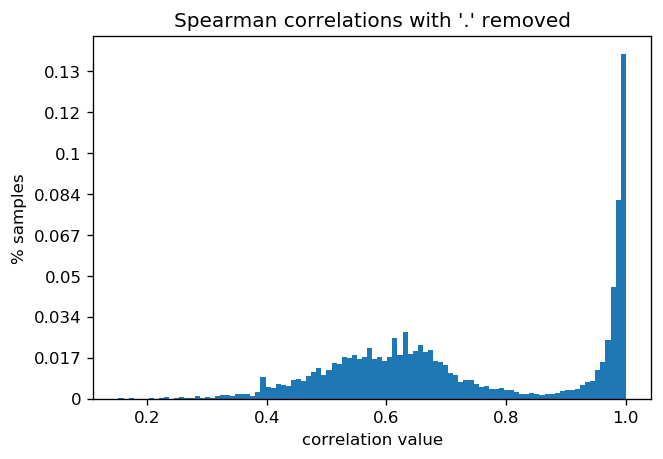

In [21]:
fig = plt.figure(dpi=120)
ax = fig.subplots()
tmp_corrs = [c for c in corrs_per if c is not None]
ax.hist(tmp_corrs, bins=100)
ax.set_title("""Spearman correlations with '.' removed""")
ax.set_yticklabels(map(lambda x: f"{x:.2g}", ax.get_yticks() / len(tmp_corrs)))
ax.set_ylabel('% samples')
ax.set_xlabel('correlation value')
plt.show()
fig.savefig('sp-corrs-dot-hist.png')
plt.close(fig)

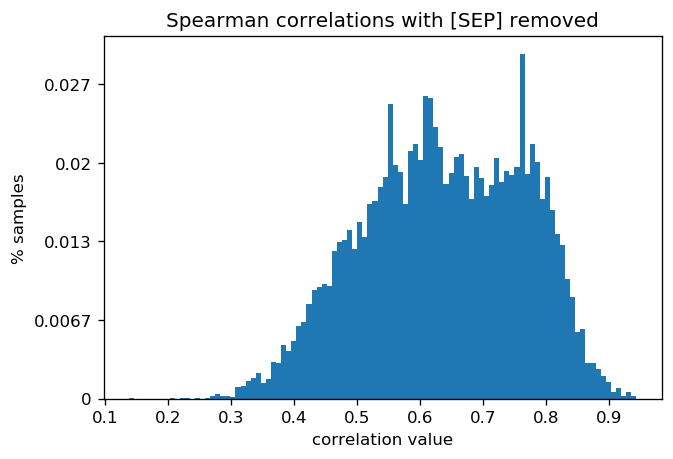

In [22]:
fig = plt.figure(dpi=120)
ax = fig.subplots()
tmp_corrs = [c for c in corrs_sep if c is not None]
ax.hist(tmp_corrs, bins=100)
ax.set_title("""Spearman correlations with [SEP] removed""")
ax.set_yticklabels(map(lambda x: f"{x:0.2g}", ax.get_yticks() / len(tmp_corrs)))
ax.set_ylabel('% samples')
ax.set_xlabel('correlation value')
plt.show()
fig.savefig('sp-corrs-sep-hist.png')
plt.close(fig)

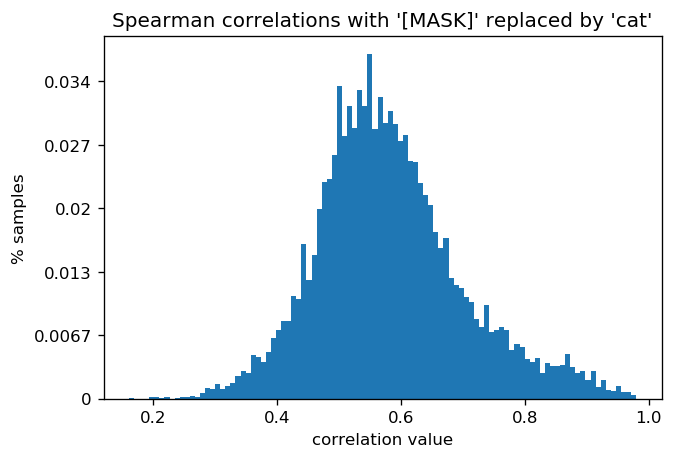

In [23]:
fig = plt.figure(dpi=120)
ax = fig.subplots()
tmp_corrs = [c for c in corrs_cat if c is not None]
ax.hist(tmp_corrs, bins=100)
ax.set_title("""Spearman correlations with '[MASK]' replaced by 'cat'""")
ax.set_yticklabels(map(lambda x: f"{x:.2g}", ax.get_yticks() / len(tmp_corrs)))
ax.set_ylabel('% samples')
ax.set_xlabel('correlation value')
plt.show()
fig.savefig('sp-corrs-cat-hist.png')
plt.close(fig)

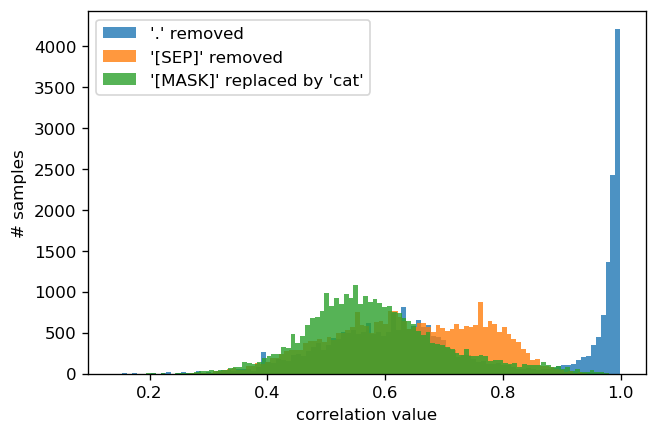

In [24]:
fig = plt.figure(dpi=120)
ax = fig.subplots()
ax.hist([c for c in corrs_per if c is not None], bins=100, label="""'.' removed""", alpha=.8)
ax.hist([c for c in corrs_sep if c is not None], bins=100, label="""'[SEP]' removed""", alpha=.8)
ax.hist([c for c in corrs_cat if c is not None], bins=100, label="""'[MASK]' replaced by 'cat'""", alpha=.8)
ax.legend(loc='best')

# ax.set_title("""Spearman correlations with [MASK]/'cat' replaced""")
# ax.set_yticklabels(map(lambda x: f"{x:.2g}", ax.get_yticks() / len(tmp_corrs)))
ax.set_ylabel('# samples')
ax.set_xlabel('correlation value')
plt.show()
fig.savefig('sp-corrs-conceptnet.png')
plt.close(fig)